In [1]:
import os
import numpy as np
import scipy.spatial.distance as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import gudhi

_tol = 1e-10

In [2]:
# Very important to compile IBloFunMatch.cc and obtain the correct executable path
EXECUTABLE_PATH = f"..\\x64\\Debug\\IBloFunMatchCPP.exe" # this is my particular path

In [3]:
def get_IBloFunMatch_subset(Dist_S, Dist_X, idS, attributes, types_list, output_dir):
    # Buffer files to write subsets and classes for communicating with C++ program 
    f_ind_sampl = output_dir + "\\indices_sample.out"
    f_dist_X = output_dir + "\\dist_X.out"
    f_dist_S = output_dir + "\\dist_S.out"
    output_data = {}
    # Compute distance matrices and save
    print(f"idS:{idS}")
    np.savetxt(f_ind_sampl, idS, fmt="%d", delimiter=" ", newline="\n")
    np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
    np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
    # Call IBloFunMatch C++ program (only for dimension 1 PH)
    ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
    # Save barcodes and representatives reading them from output files
    data_read = []
    for attribute_name, typename in zip(attributes, types_list):
        print(f"attribute:{attribute_name}, type:{typename}")
        print(output_dir + "\\" + attribute_name + ".out")
        with open(output_dir + "\\" + attribute_name + ".out") as file:
            for line in file:
                if(attribute_name == "induced_matching"):
                    data_read.append(int(line))
                else:
                    data_line = line.split(" ")
                    if (typename=="int"): # lines end with additional space
                        data_line=data_line[:-1]
                    data_read.append(list(np.array(data_line).astype(typename)))
                # end if else 
            # end reading file lines 
            if typename=="float":
                output_data[attribute_name] = np.array(data_read)
            else:
                output_data[attribute_name] = data_read.copy()
            # end if-else 
        # end opening file 
        data_read.clear()
    # end saving all attributes 
    # end for 
    return output_data
# def get_IBloFunMatch_output_range

## Define a moving point cloud

In [4]:
def take_sample(point_cloud, no_samples, seed=None):
    """ From PerMaViss.py
    """
    if seed != None:
        np.random.seed(seed)
    no_points = len(point_cloud)
    no_samples = min(no_points, no_samples)
    Dist = dist.squareform(dist.pdist(point_cloud))
    k = int(np.random.rand() * no_points) - 1
    selection = [k]
    point_selection = [point_cloud[k]]
    for i in range(no_samples-1):
        not_selected = np.setdiff1d(range(no_points), selection)
        rest_Dist = np.min(Dist[not_selected][:, selection], axis=1)
        k = not_selected[np.argmax(rest_Dist)]
        selection.append(k)
        point_selection.append(point_cloud[k])

    return np.array(point_selection)

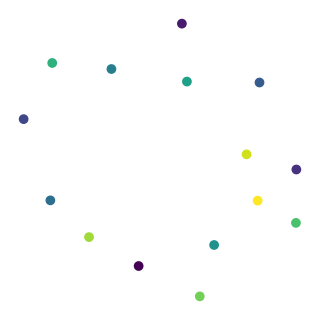

In [5]:
point_cloud = []
RandGen = np.random.default_rng(5)
num_samples, low_rad, big_rad = 40, 4, 7
radii = RandGen.uniform(low_rad, big_rad, num_samples)
angles = RandGen.uniform(0,2*np.pi, num_samples)
C1 = np.array([np.cos(angles)*radii, np.sin(angles)*radii]).T
num_samples = 15
C1 = take_sample(C1, num_samples, seed=4)
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes((0,0,1,1))
viridis_cm = mpl.colormaps["viridis"].resampled(num_samples)
colorlist = [viridis_cm(idx/num_samples) for idx in range(num_samples)]
ax.scatter(C1[:,0], C1[:,1], color=colorlist)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("plots/points_fleet.png")

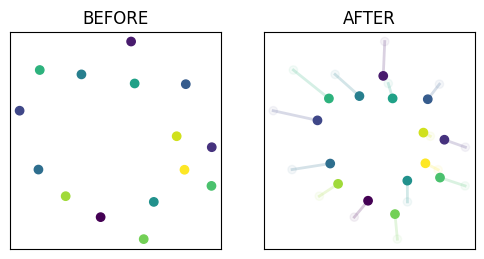

In [7]:
Csmall = C1*0.7 + (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*0.9 + [0.7,0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].scatter(C1[:,0], C1[:,1], color=colorlist, zorder=2)
ax[1].scatter(C1[:,0], C1[:,1], color=colorlist, alpha=0.05, zorder=1.5)
ax[1].scatter(Csmall[:,0], Csmall[:,1], color=colorlist, zorder=2)
# Draw trajectory lines
for ptA, ptB, color in zip(C1, Csmall, colorlist):
    new_line = mpl.lines.Line2D([ptA[0], ptB[0]], [ptA[1], ptB[1]], lw=2, color=color, zorder=1, alpha=0.2)
    ax[1].add_line(new_line)
# Set axis parameters
for ax_it in ax:
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.set_aspect("equal")
# end for 
ax[0].set_title("BEFORE")
ax[1].set_title("AFTER")
plt.savefig("plots/points_fleet.png")

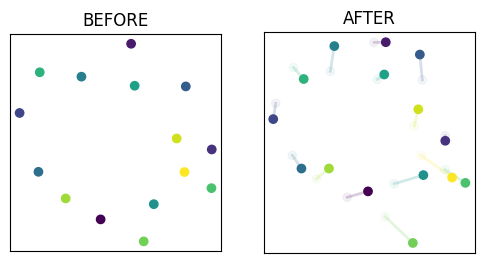

In [8]:
RandGen = np.random.default_rng(5)
C2 = C1*1.1 + (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*3 + [0.7,0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].scatter(C1[:,0], C1[:,1], color=colorlist, zorder=2)
ax[1].scatter(C1[:,0], C1[:,1], color=colorlist, alpha=0.05, zorder=1.5)
ax[1].scatter(C2[:,0], C2[:,1], color=colorlist, zorder=2)
# Draw trajectory lines
for ptA, ptB, color in zip(C1, C2, colorlist):
    new_line = mpl.lines.Line2D([ptA[0], ptB[0]], [ptA[1], ptB[1]], lw=2, color=color, zorder=1, alpha=0.2)
    ax[1].add_line(new_line)
# Set axis parameters
for ax_it in ax:
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.set_aspect("equal")
# end for 
ax[0].set_title("BEFORE")
ax[1].set_title("AFTER")
plt.savefig("plots/points_fleet_2.png")

### Depict middle distance $d_M$ compared to $d_1$ and $d_2$

In [9]:
import gudhi
import scipy.spatial.distance as dist

In [10]:
def plot_complex(Dist_X, points, max_rad, ax):
    rips_complex = gudhi.RipsComplex(distance_matrix=Dist_X, max_edge_length=max_rad)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    for filtered_value in simplex_tree.get_filtration():
        spx = filtered_value[0]
        if len(spx)==2:
            edge = points[spx]
            ax.add_line(mpl.lines.Line2D(edge[:,0], edge[:,1], lw=3, color="black", zorder=1))
        elif len(spx)==3:
            triangle = points[spx] 
            ax.add_patch(mpl.patches.Polygon(triangle, facecolor="black", alpha=0.3, zorder=0.5))
        # end if else 
    # end for 
# def plot_complex

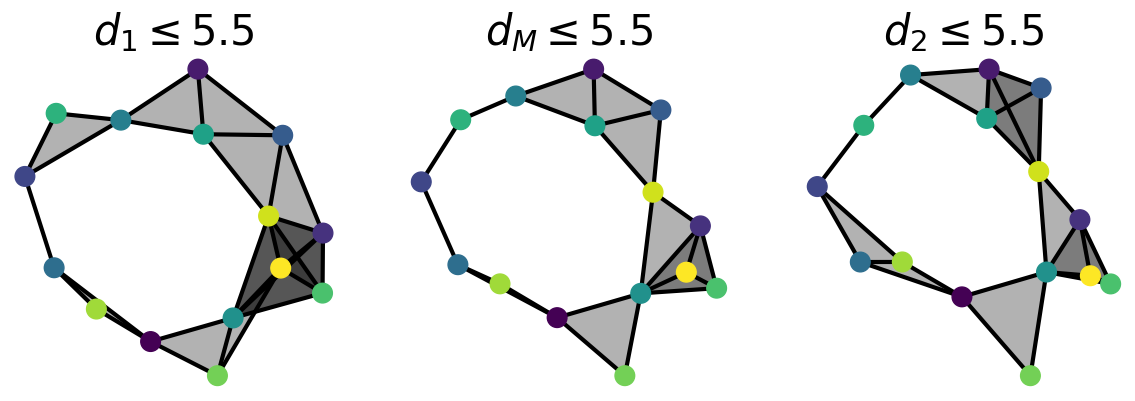

In [11]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
max_rad =5.5
point_list = [C1, (C1+C2)/2, C2]
# Compute Distance Matrices
Dist_C1 = dist.squareform(dist.pdist(C1))
Dist_C2 = dist.squareform(dist.pdist(C2))
Dist_M = np.maximum(Dist_C1, Dist_C2)
Dist_list = [Dist_C1, Dist_M, Dist_C2]
title_list = [f"$d_1 \leq {max_rad:.1f}$", f"$d_M \leq {max_rad:.1f}$", f"$d_2 \leq {max_rad:.1f}$"]
for idx, (X, Dist_X) in enumerate(zip(point_list, Dist_list)):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color=colorlist, s=200)
    plot_complex(Dist_X, X, max_rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_frame_on(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=30)
# end for 
fig.tight_layout()
plt.savefig("plots/VR_cpx_Middle.png")

## Example 1:

In [12]:
%%capture
# Recompute point cloud
RandGen = np.random.default_rng(6)
num_samples, low_rad, big_rad = 40, 4, 7
radii = RandGen.uniform(low_rad, big_rad, num_samples)
angles = RandGen.uniform(0,2*np.pi, num_samples)
C1 = np.array([np.cos(angles)*radii, np.sin(angles)*radii]).T
num_samples = 15
C1 = take_sample(C1, num_samples, seed=4)
C2 = C1*0.6 + (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*1.5 + [1,0]
C1 += (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*1.5
# Compute Distance Matrices
Dist_C1 = dist.squareform(dist.pdist(C1))
Dist_C2 = dist.squareform(dist.pdist(C2))
Dist_M = np.maximum(Dist_C1, Dist_C2)
assert(np.all(Dist_C1 <= Dist_M))
assert(np.all(Dist_C2 <= Dist_M))
idS = [i for i in range(Dist_M.shape[0])]
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
output_match_C1 = get_IBloFunMatch_subset(Dist_M, Dist_C1, idS, attributes, types_list, output_dir)
output_match_C2 = get_IBloFunMatch_subset(Dist_M, Dist_C2, idS, attributes, types_list, output_dir)
# Prepare intervals for plotting
persistence = [(0, list(bar)) for bar in output_match_C1["X_barcode"]]
persistence += [(1, list(bar)) for bar in output_match_C2["X_barcode"]]
persistence += [(2, list(bar)) for bar in output_match_C1["S_barcode"]]
max_rad = max(np.max(output_match_C1["S_barcode"]), np.max(output_match_C1["X_barcode"]), np.max(output_match_C2["X_barcode"]))
persistence += [(3, [0, max_rad])]

C:\Users\Alvaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gudhi\persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


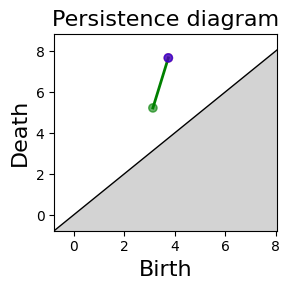

In [13]:
# Plot
colorlist = ["red", "green", "blue", "white"]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
gudhi.plot_persistence_diagram(persistence, axes=ax, colormap=colorlist)
# Plot matchings 
for idx_output, output_match in enumerate([output_match_C1, output_match_C2]):
    X_barcode = output_match["X_barcode"]
    S_barcode = output_match["S_barcode"]
    for idx, idx_match in enumerate(output_match["induced_matching"]):
        if idx_match<0:
            continue
        edge = np.array([S_barcode[idx],X_barcode[idx_match]])
        ax.plot(edge[:,0], edge[:,1], color=colorlist[idx_output], linewidth=2, zorder=0.5)
ax.get_legend().set_visible(False)
fig.tight_layout()
plt.savefig("plots/Matchings_fleet.png")

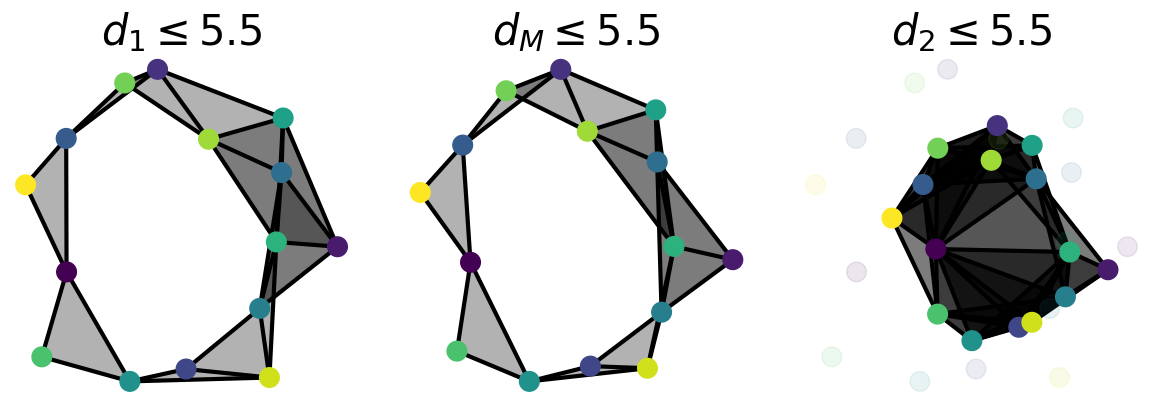

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
max_rad =5.5
point_list = [C1, (C1+C2)/2, C2]
# Compute Distance Matrices
Dist_C1 = dist.squareform(dist.pdist(C1))
Dist_C2 = dist.squareform(dist.pdist(C2))
Dist_M = np.maximum(Dist_C1, Dist_C2)
Dist_list = [Dist_C1, Dist_M, Dist_C2]
colorlist = [viridis_cm(idx/Dist_M.shape[0]) for idx in range(Dist_M.shape[0])]
title_list = [f"$d_1 \leq {max_rad:.1f}$", f"$d_M \leq {max_rad:.1f}$", f"$d_2 \leq {max_rad:.1f}$"]
for idx, (X, Dist_X) in enumerate(zip(point_list, Dist_list)):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color=colorlist, s=200)
    plot_complex(Dist_X, X, max_rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_frame_on(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=30)
# end for 
ax[2].scatter(C1[:,0], C1[:,1], color=colorlist, s=200, alpha=0.1)
fig.tight_layout()
plt.savefig("plots/VR_cpx_match_first.png")

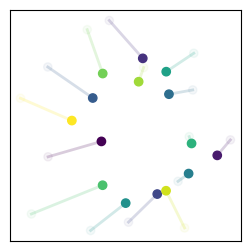

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.scatter(C1[:,0], C1[:,1], color=colorlist, alpha=0.05, zorder=1.5)
ax.scatter(C2[:,0], C2[:,1], color=colorlist, zorder=2)
# Draw trajectory lines
for ptA, ptB, color in zip(C1, C2, colorlist):
    new_line = mpl.lines.Line2D([ptA[0], ptB[0]], [ptA[1], ptB[1]], lw=2, color=color, zorder=1, alpha=0.2)
    ax.add_line(new_line)
# Set axis parameters
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")
# end for 
plt.savefig("plots/points_move_first.png")

## Example 2

In [16]:
%%capture
# Recompute point cloud
RandGen = np.random.default_rng(5)
num_samples, low_rad, big_rad = 40, 4, 7
radii = RandGen.uniform(low_rad, big_rad, num_samples)
angles = RandGen.uniform(0,2*np.pi, num_samples)
C1 = np.array([np.cos(angles)*radii, np.sin(angles)*radii]).T
num_samples = 15
C1 = take_sample(C1, num_samples, seed=4)
C2 = C1 + (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*3 + [1,0]
C1 += (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*3
# Compute Distance Matrices
Dist_C1 = dist.squareform(dist.pdist(C1))
Dist_C2 = dist.squareform(dist.pdist(C2))
Dist_M = np.maximum(Dist_C1, Dist_C2)
assert(np.all(Dist_C1 <= Dist_M))
assert(np.all(Dist_C2 <= Dist_M))
idS = [i for i in range(Dist_M.shape[0])]
output_dir = "output"
# Initialize variables to range over 
attributes = ["X_barcode", "S_barcode", "X_reps", "S_reps", "S_reps_im", "pm_matrix", "induced_matching"]
types_list = ["float", "float", "int", "int", "int", "int", "int", "int"]
output_match_C1 = get_IBloFunMatch_subset(Dist_M, Dist_C1, idS, attributes, types_list, output_dir)
output_match_C2 = get_IBloFunMatch_subset(Dist_M, Dist_C2, idS, attributes, types_list, output_dir)
# Prepare intervals for plotting
persistence = [(0, list(bar)) for bar in output_match_C1["X_barcode"]]
persistence += [(1, list(bar)) for bar in output_match_C2["X_barcode"]]
persistence += [(2, list(bar)) for bar in output_match_C1["S_barcode"]]
max_rad = max(np.max(output_match_C1["S_barcode"]), np.max(output_match_C1["X_barcode"]), np.max(output_match_C2["X_barcode"]))
persistence += [(3, [0, max_rad])]

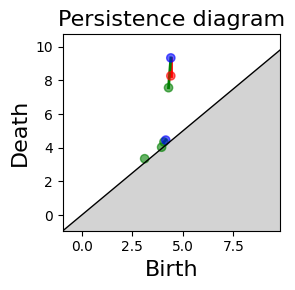

In [17]:
# Plot
colorlist = ["red", "green", "blue", "white"]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
gudhi.plot_persistence_diagram(persistence, axes=ax, colormap=colorlist)
# Plot matchings 
for idx_output, output_match in enumerate([output_match_C1, output_match_C2]):
    X_barcode = output_match["X_barcode"]
    S_barcode = output_match["S_barcode"]
    for idx, idx_match in enumerate(output_match["induced_matching"]):
        if idx_match<0:
            continue
        edge = np.array([S_barcode[idx],X_barcode[idx_match]])
        ax.plot(edge[:,0], edge[:,1], color=colorlist[idx_output], linewidth=2, zorder=0.5)
ax.get_legend().set_visible(False)
fig.tight_layout()
plt.savefig("plots/Matchings_fleet_second.png")

In [18]:
persistence

[(0, [4.40594, 8.27434]),
 (1, [3.11138, 3.34867]),
 (1, [3.95021, 4.03137]),
 (1, [4.06507, 4.34469]),
 (1, [4.29273, 7.57029]),
 (2, [4.15558, 4.45534]),
 (2, [4.40594, 9.34225]),
 (3, [0, 9.34225])]

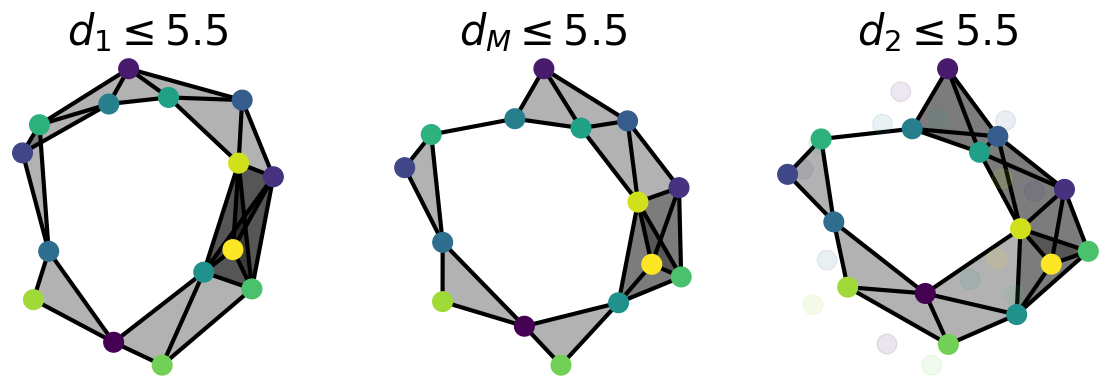

In [19]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
max_rad =5.5
point_list = [C1, (C1+C2)/2, C2]
# Compute Distance Matrices
Dist_C1 = dist.squareform(dist.pdist(C1))
Dist_C2 = dist.squareform(dist.pdist(C2))
Dist_M = np.maximum(Dist_C1, Dist_C2)
Dist_list = [Dist_C1, Dist_M, Dist_C2]
colorlist = [viridis_cm(idx/Dist_M.shape[0]) for idx in range(Dist_M.shape[0])]
title_list = [f"$d_1 \leq {max_rad:.1f}$", f"$d_M \leq {max_rad:.1f}$", f"$d_2 \leq {max_rad:.1f}$"]
for idx, (X, Dist_X) in enumerate(zip(point_list, Dist_list)):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color=colorlist, s=200)
    plot_complex(Dist_X, X, max_rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_frame_on(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=30)
# end for 

ax[2].scatter(C1[:,0], C1[:,1], color=colorlist, s=200, alpha=0.1)
fig.tight_layout()
plt.savefig("plots/VR_cpx_match_second.png")

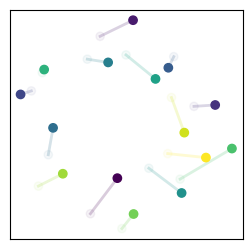

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.scatter(C1[:,0], C1[:,1], color=colorlist, alpha=0.05, zorder=1.5)
ax.scatter(C2[:,0], C2[:,1], color=colorlist, zorder=2)
# Draw trajectory lines
for ptA, ptB, color in zip(C1, C2, colorlist):
    new_line = mpl.lines.Line2D([ptA[0], ptB[0]], [ptA[1], ptB[1]], lw=2, color=color, zorder=1, alpha=0.2)
    ax.add_line(new_line)
# Set axis parameters
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")
# end for 
plt.savefig("plots/points_move_second.png")